# Getting started with prenspire

In [1]:
import random
from pathlib import Path
from clophfit.prenspire import prenspire

%load_ext autoreload
%autoreload 2
tpath = Path("../../tests/EnSpire")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from clophfit.binding.fitting import plot_emcee
import arviz as az
import lmfit
import corner

In [3]:
ef1 = prenspire.EnspireFile(tpath / "h148g-spettroC.csv")
ef2 = prenspire.EnspireFile(tpath / "e2-T-without_sample_column.csv")
ef3 = prenspire.EnspireFile(tpath / "24well_clop0_95.csv")

In [4]:
ef3.wells, ef3._wells_platemap, ef3._platemap

(['A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'C01', 'C02', 'C03'],
 ['A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'C01', 'C02', 'C03'],
 [['A', '  ', '  ', '- ', '- ', '- ', '- '],
  ['B', '- ', '- ', '  ', '  ', '  ', '  '],
  ['C', '- ', '- ', '- ', '  ', '  ', '  '],
  ['D', '  ', '  ', '  ', '  ', '  ', '  ']])

In [5]:
ef1.__dict__.keys()

dict_keys(['file', 'verbose', 'metadata', 'measurements', 'wells', '_ini', '_fin', '_wells_platemap', '_platemap'])

In [6]:
ef1.measurements.keys(), ef2.measurements.keys()

(dict_keys(['A']), dict_keys(['B', 'A', 'C', 'D', 'E', 'F', 'G', 'H']))

when testing each spectra for the presence of a single wavelength in the appropriate monochromator

In [7]:
ef2.measurements["A"]["metadata"]

{'temp': '25',
 'Monochromator': 'Excitation',
 'Min wavelength': '400',
 'Max wavelength': '510',
 'Wavelength': '530',
 'Using of excitation filter': 'Top',
 'Measurement height': '8.9',
 'Number of flashes': '50',
 'Number of flashes integrated': '50',
 'Flash power': '100'}

In [8]:
ef2.measurements["A"].keys()

dict_keys(['metadata', 'lambda', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07'])

In [9]:
random.seed(11)
random.sample(ef1.measurements["A"]["F01"], 7)

[2163.0, 607.0, 1846.0, 517.0, 572.0, 2145.0, 2028.0]

In [10]:
en1 = prenspire.ExpNote(tpath / "h148g-spettroC-nota")
en1

ExpNote(note_file=PosixPath('../../tests/EnSpire/h148g-spettroC-nota'), verbose=0, wells=['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'F01', 'F02', 'F03', 'F04', 'F05', 'G01', 'G02', 'G03', 'G04', 'G05'], _note_list=[['Well', 'pH', 'Chloride'], ['A01', '5.2', '0'], ['A02', '5.2', '6.7'], ['A03', '5.2', '13.3'], ['A04', '5.2', '26.7'], ['A05', '5.2', '40'], ['A06', '5.2', '60'], ['A07', '5.2', '87'], ['A08', '5.2', '120'], ['A09', '5.2', '267'], ['A10', '5.2', '400'], ['A11', '5.2', '667'], ['B01', '6.3', '0'], ['B02', '6.3', '6.7'], ['B03', '6.3', '13.3'], ['B04', '6.3', '26.7'], ['B05', '6.3', '40'], ['B06', '6.3', '60'], ['B07', '6.3', '87'], ['B08'

In [11]:
ef = prenspire.EnspireFile(tpath / "G10.csv")

In [12]:
en1.build_titrations(ef1)
en1.titrations[0].data["A"]

,5.2,6.3,7.4,8.1,8.2
,A01,B01,C01,D01,E01
lambda,,,,,
272.0,3151.0,4181.0,16413.0,29192.0,28816.0
273.0,3130.0,4204.0,16926.0,29909.0,29545.0
274.0,3043.0,4232.0,17331.0,30900.0,30750.0
275.0,3079.0,4283.0,17680.0,31717.0,31547.0
276.0,2975.0,4264.0,18020.0,32564.0,32336.0
...,...,...,...,...,...
496.0,636.0,4689.0,43230.0,87203.0,87842.0
497.0,683.0,4923.0,45173.0,89719.0,90666.0


In [13]:
fp = tpath / "h148g-spettroC-nota.csv"
n1 = prenspire.Note(fp, verbose=1)
n1.build_titrations(ef1)

Wells ['A02', 'A03']...['G04', 'G05'] generated.


In [14]:
from clophfit.binding.fitting import analyze_spectra, analyze_spectra_glob, Dataset

spectra = n1.titrations["H148G"][20.0]["Cl_0.0"]["A"]

In [15]:
fp = tpath / "NTT-G10_note.csv"
nn = prenspire.Note(fp, verbose=1)
nn.build_titrations(ef)

Wells ['D02', 'D03']...['G07', 'G08'] generated.


In [16]:
tit = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]
# tit = nn.titrations['NTT-G10'][37.0]['Cl_0.0']
r = analyze_spectra_glob(tit, Dataset({}, {}, True))

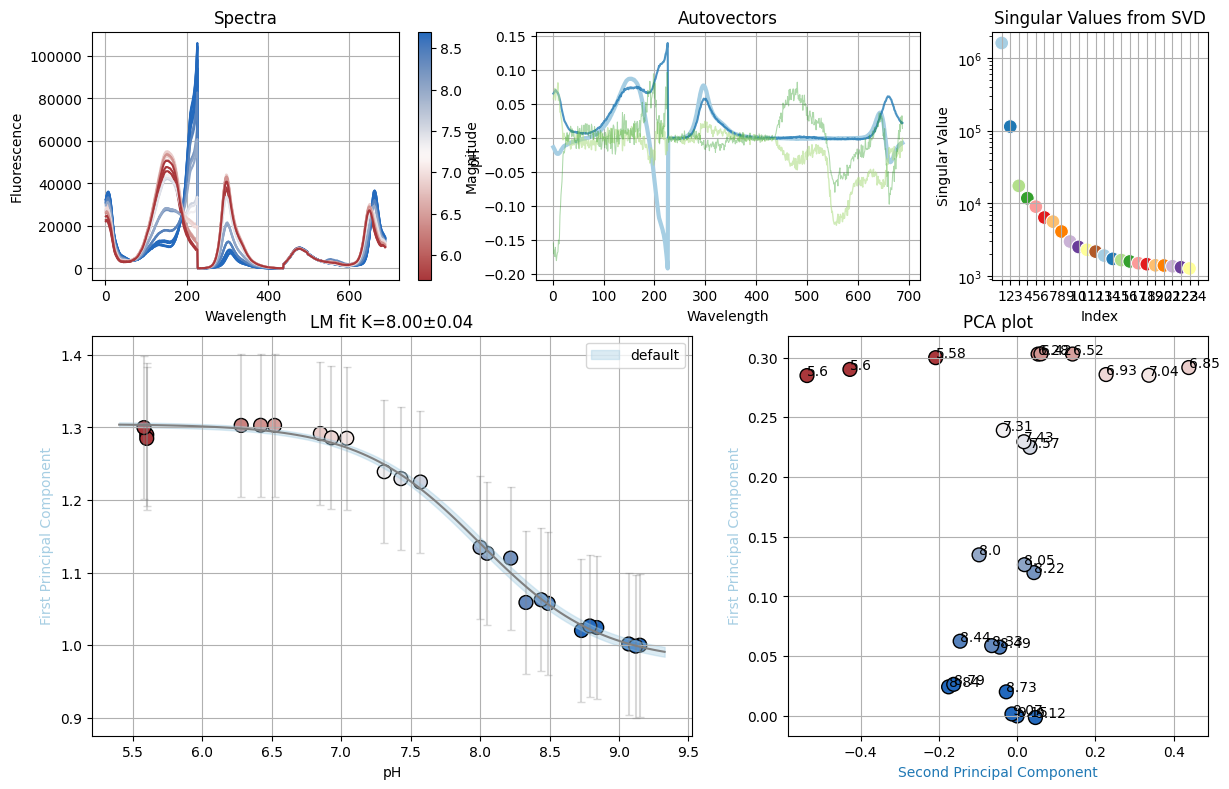

In [17]:
plt.show()
r.svd.figure

In [18]:
r.svd.mini.params

name,value,initial value,min,max,vary
S0_default,1.00000000,1.0,0.00000000,inf,True
S1_default,1.29988413,1.299884129191042,-inf,inf,True
K,8.00000000,8.0,3.00000000,11.0000000,True


In [19]:
result_emcee = r.svd.mini.emcee()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [37.60427069 28.39615993 28.61227199]


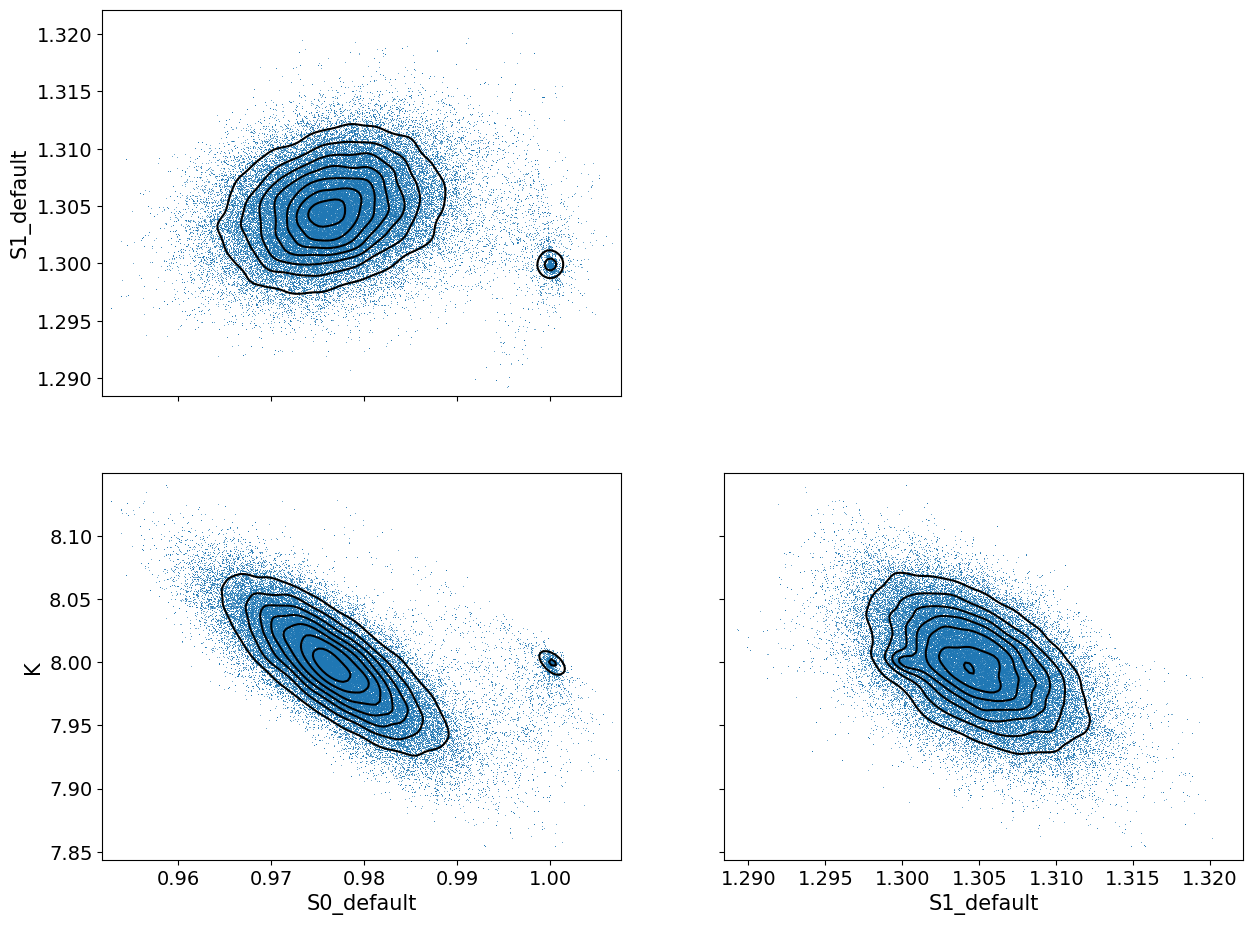

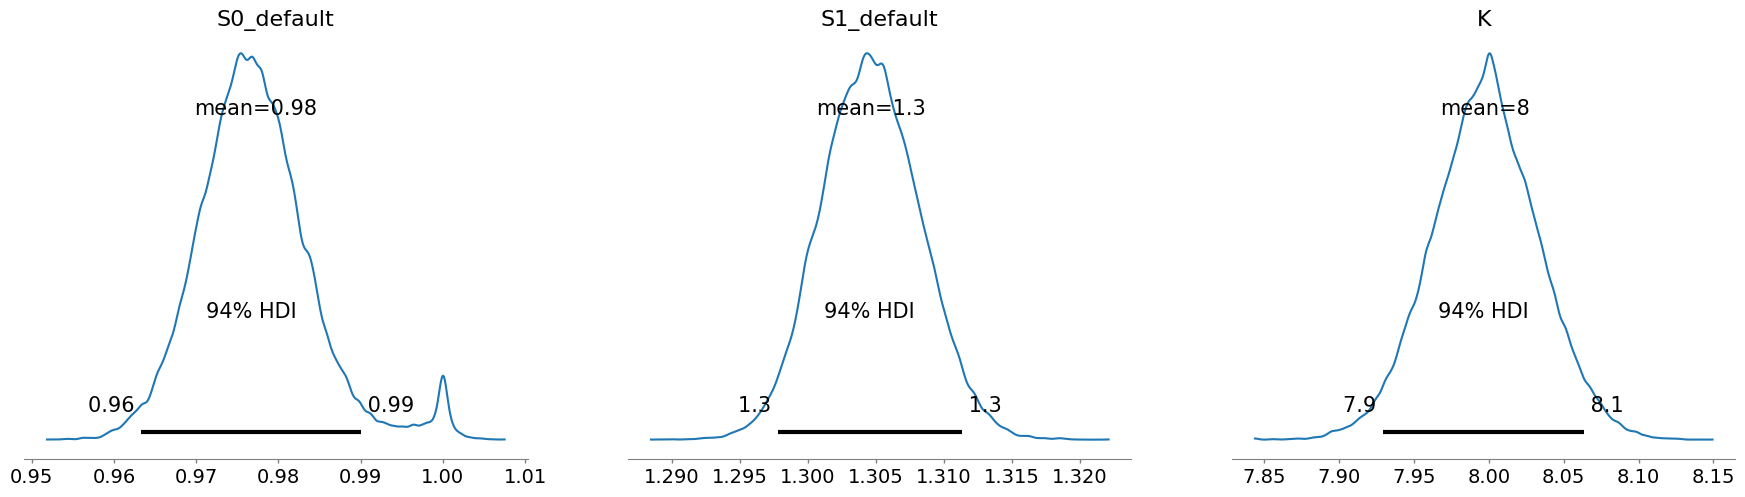

In [20]:
plot_emcee(result_emcee)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:21<00:00, 82.64it/s]


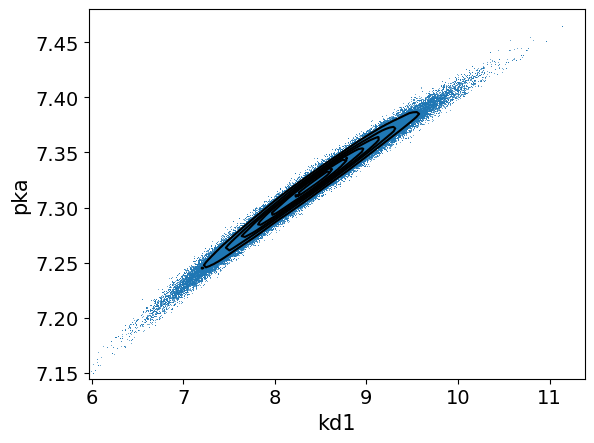

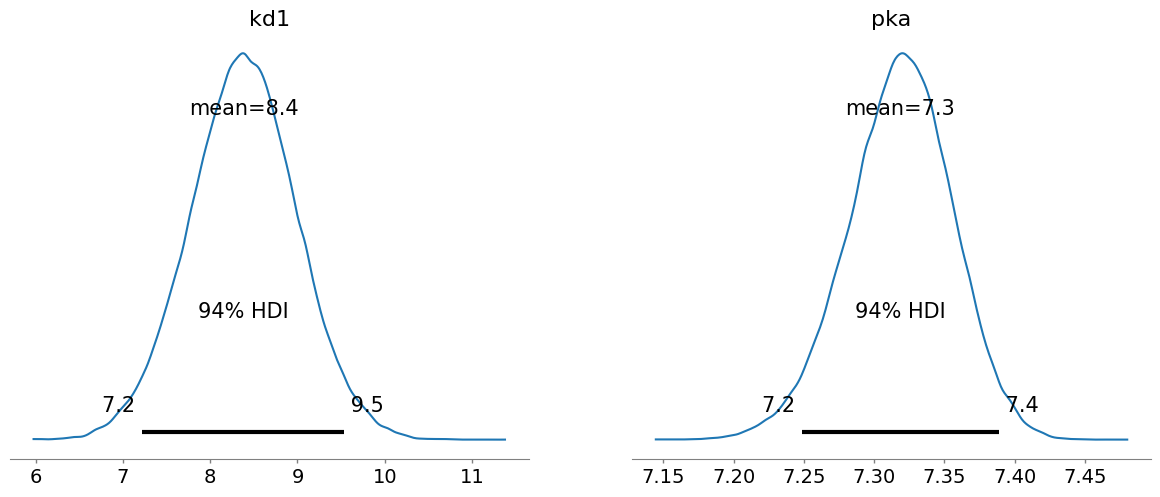

In [21]:
xx = np.array([5.2, 6.3, 7.4, 8.1, 8.2])
yy = np.array([6.05, 12.2, 20.38, 48.2, 80.3])


def kd(x, kd1, pka):
    return kd1 * (1 + 10 ** (pka - x)) / 10 ** (pka - x)


model = lmfit.Model(kd)
params = lmfit.Parameters()
params.add("kd1", value=10.0)
params.add("pka", value=6.6)
result = model.fit(yy, params, x=xx)
result_emcee = result.emcee(steps=1800, burn=150)

plot_emcee(result_emcee)

In [22]:
f_res = analyze_spectra(
    nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["C"], is_ph=True, band=None
)

In [23]:
f_res.result.params

name,value,standard error,relative error,initial value,min,max,vary
S0_default,1.02293521,0.00563096,(0.55%),1.0,0.00000000,inf,True
S1_default,0.69503608,0.00341428,(0.49%),0.6985379463390999,-inf,inf,True
K,7.99565999,0.03434536,(0.43%),8.0,3.00000000,11.0000000,True


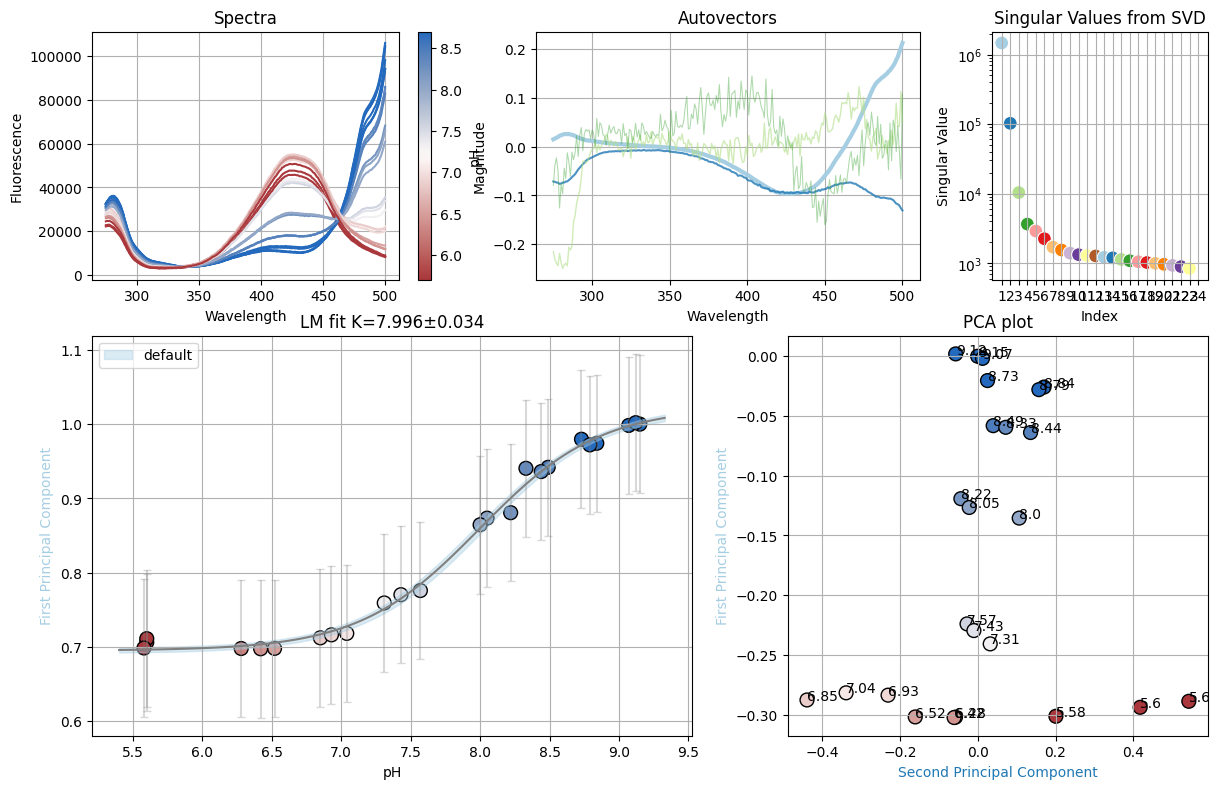

In [24]:
f_res.figure

In [25]:
spectra_A = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["A"]
spectra_C = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["C"]
spectra_D = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["D"]
resA = analyze_spectra(spectra_A, "pH", (466, 510))
resC = analyze_spectra(spectra_C, "pH", (470, 500))
resD = analyze_spectra(spectra_D, "pH", (450, 600))

In [26]:
# Combine the data from all datasets
x_combined = {
    "A": resA.mini.userargs[0]["default"].x,
    "C": resC.mini.userargs[0]["default"].x,
    "D": resD.mini.userargs[0]["default"].x,
}
y_combined = {
    "A": resA.mini.userargs[0]["default"].y,
    "C": resC.mini.userargs[0]["default"].y,
    "D": resD.mini.userargs[0]["default"].y,
}

In [27]:
dbands = {"A": (466, 510), "C": (470, 500), "D": (450, 600)}
dbands = {"A": (466, 510), "C": (470, 500)}
# dbands = {"A": (466, 510), }
# dbands = {}
ds = Dataset(x_combined, y_combined, is_ph=True)
for k in list(ds):
    if k not in dbands:
        del ds[k]
tup = analyze_spectra_glob(nn.titrations["NTT-G10"][20.0]["Cl_0.0"], ds, dbands)

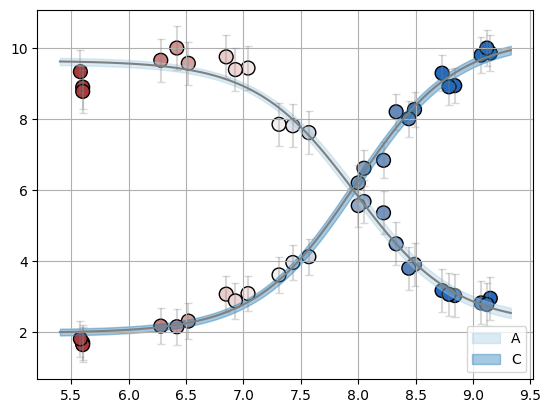

In [28]:
tup.bands.figure

In [29]:
from clophfit.__main__ import _print_result

_print_result(tup.bands, "", "")

from clophfit.binding.fitting import fit_binding_glob

res = fit_binding_glob(ds, True)


Best fit using '' band:

      99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 S0_A:   1.65   1.86   2.05   2.23   2.41   2.59   2.78
 S1_A:   9.23   9.38   9.51   9.64   9.77   9.91  10.06
 S0_C:   9.84   9.99  10.14  10.29  10.44  10.60  10.78
 S1_C:   1.67   1.78   1.89   1.98   2.08   2.18   2.29
 K   :   7.86   7.90   7.94   7.97   8.01   8.04   8.08

 Plot saved in ''.



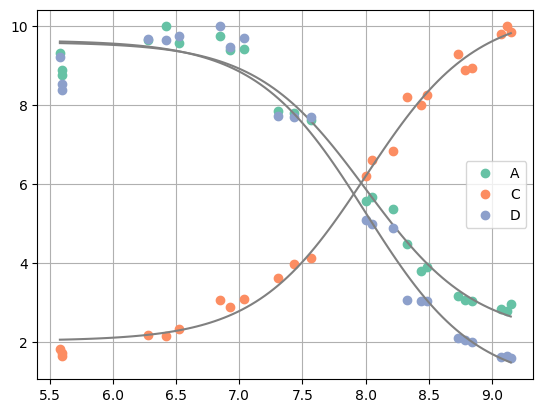

In [24]:
from clophfit.binding.fitting import fit_binding_glob

f, res, mini = fit_binding_glob(ds)

In [68]:
en1._note_list

conc_well = [(line[1], line[0]) for line in en1._note_list if line[2] == "0"]
conc = [float(tpl[0]) for tpl in conc_well]
well = [tpl[1] for tpl in conc_well]
conc_well, conc, well

([('5.2', 'A01'),
  ('6.3', 'B01'),
  ('7.4', 'C01'),
  ('8.1', 'D01'),
  ('8.2', 'E01')],
 [5.2, 6.3, 7.4, 8.1, 8.2],
 ['A01', 'B01', 'C01', 'D01', 'E01'])

In [ ]:
False@dataclass
class Metadata:
    
@dataclass
class Datum:
    well: str
    pH: float
    Cl: float
    T: float
    mut: str
    labels: list[str]
    metadata: dict[str, Metadata]


In [21]:
en1.wells[:7]

['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07']

In [22]:
en1._note_list[:5]

[['Well', 'pH', 'Chloride'],
 ['A01', '5.2', '0'],
 ['A02', '5.2', '6.7'],
 ['A03', '5.2', '13.3'],
 ['A04', '5.2', '26.7']]

In [23]:
en1.wells == ef1.wells, en1.wells == ef2.wells

(True, False)

In [24]:
en1.build_titrations(ef1)

In [14]:
en1.__dict__.keys()

dict_keys(['note_file', 'verbose', 'wells', '_note_list', 'titrations', 'pH_values'])

In [15]:
en1.pH_values

['5.2', '6.3', '7.4', '8.1', '8.2']

In [16]:
tit0 = en1.titrations[0]
tit3 = en1.titrations[3]

In [17]:
tit0.__dict__.keys()

dict_keys(['conc', 'data', 'cl'])

In [18]:
tit0.conc, tit0.cl, tit3.conc, tit3.ph

([5.2, 6.3, 7.4, 8.1, 8.2],
 '0',
 [0.0, 6.7, 13.3, 26.7, 40.0, 60.0, 87.0, 120.0, 267.0, 400.0, 667.0],
 '7.4')

In [19]:
tit0.data["A"]

,5.2,6.3,7.4,8.1,8.2
,A01,B01,C01,D01,E01
lambda,,,,,
272.0,3151.0,4181.0,16413.0,29192.0,28816.0
273.0,3130.0,4204.0,16926.0,29909.0,29545.0
274.0,3043.0,4232.0,17331.0,30900.0,30750.0
275.0,3079.0,4283.0,17680.0,31717.0,31547.0
276.0,2975.0,4264.0,18020.0,32564.0,32336.0
...,...,...,...,...,...
496.0,636.0,4689.0,43230.0,87203.0,87842.0
497.0,683.0,4923.0,45173.0,89719.0,90666.0


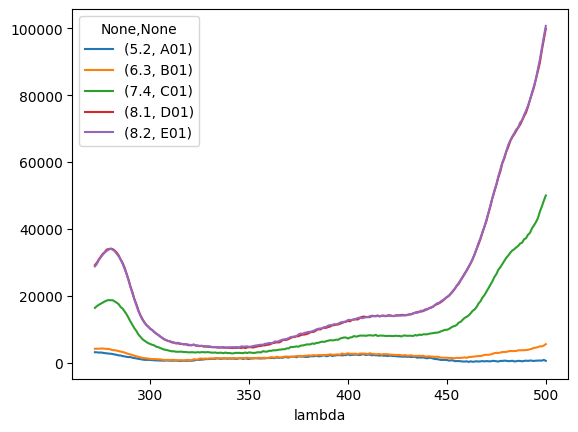

In [20]:
tit0.plot()

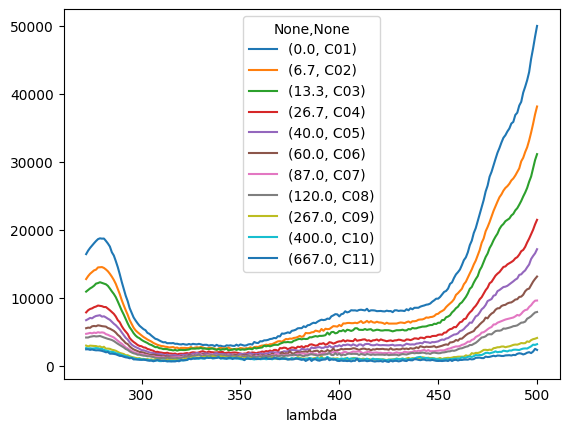

In [21]:
tit3.plot()